# Using StatsModels to run a Generalized Linear Mixed‐effects Model

In [1]:
#import dependencies 

import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [2]:
#load data

df = pd.read_excel('Datasets/AIS_fmr1_GLMM.xlsx')
print (df.columns)
df.head()

Index(['Species', 'Model', 'Strain', 'Brain region', 'Animal', 'Genotype',
       'Age', 'Parent', 'Gender', 'Location', 'AIS length'],
      dtype='object')


,Species,Model,Strain,Brain region,Animal,Genotype,Age,Parent,Gender,Location,AIS length
0,Rat,Fmr1,LE,CA1,214,WT,P27,Fmr1/GFP19,M,Bangalore,20.899
1,Rat,Fmr1,LE,CA1,214,WT,P27,Fmr1/GFP19,M,Bangalore,28.109
2,Rat,Fmr1,LE,CA1,214,WT,P27,Fmr1/GFP19,M,Bangalore,25.490
3,Rat,Fmr1,LE,CA1,214,WT,P27,Fmr1/GFP19,M,Bangalore,30.017
4,Rat,Fmr1,LE,CA1,214,WT,P27,Fmr1/GFP19,M,Bangalore,23.697


In [3]:
print ('Unique values are:\n', df.nunique()) #check number of unique values in each column in order to decide which columns to drop
print ()
print ('Null values are:\n', df.isnull().sum()) #check for null values

Unique values are:
 Species            1
Model              1
Strain             1
Brain region      11
Animal            12
Genotype           2
Age                2
Parent             2
Gender             1
Location           1
AIS length      8889
dtype: int64

Null values are:
 Species         0
Model           0
Strain          0
Brain region    0
Animal          0
Genotype        0
Age             0
Parent          0
Gender          0
Location        0
AIS length      0
dtype: int64


In [4]:
df.drop(['Species', 'Model', 'Strain', 'Gender', 'Location'], axis=1, inplace = True)
df.head() #columns dropped

,Brain region,Animal,Genotype,Age,Parent,AIS length
0,CA1,214,WT,P27,Fmr1/GFP19,20.899
1,CA1,214,WT,P27,Fmr1/GFP19,28.109
2,CA1,214,WT,P27,Fmr1/GFP19,25.490
3,CA1,214,WT,P27,Fmr1/GFP19,30.017
4,CA1,214,WT,P27,Fmr1/GFP19,23.697


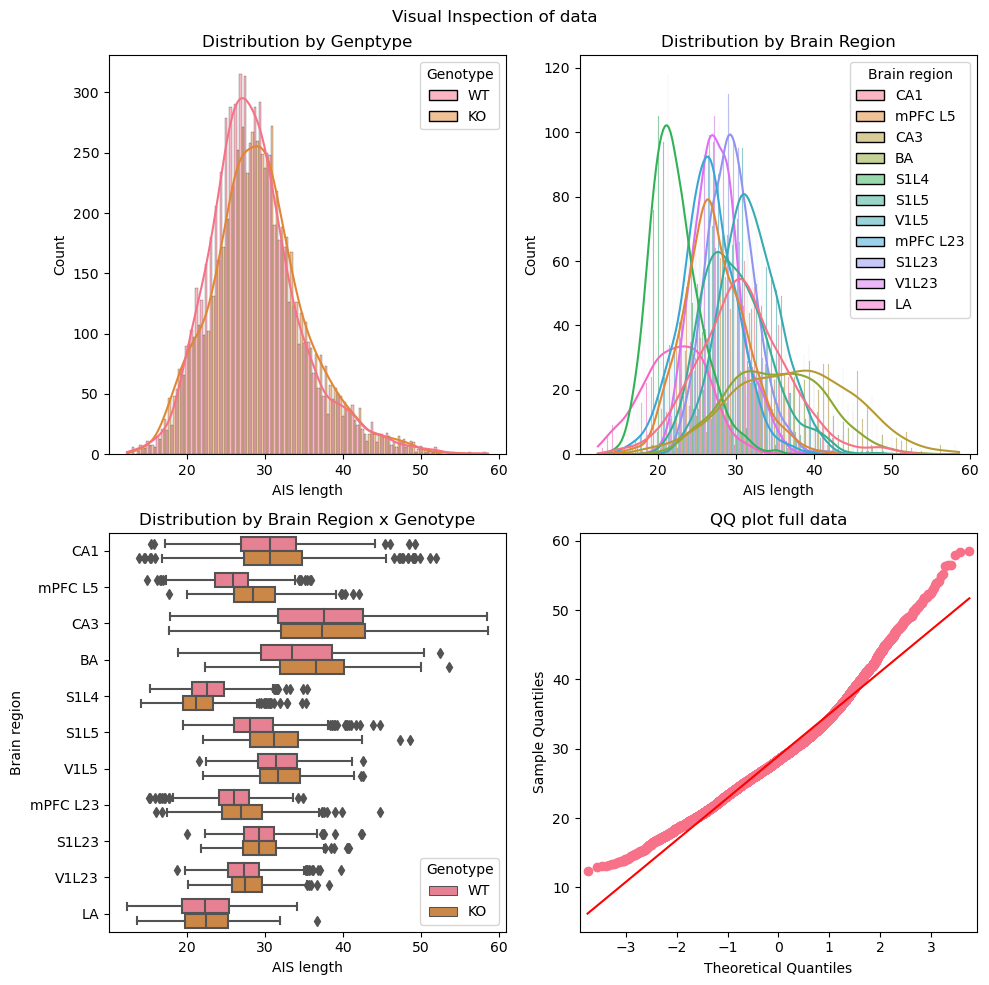

In [5]:
sns.set_palette("husl", 11)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Visual Inspection of data')
sns.histplot(ax = axs[0,0], data=df, x="AIS length", hue="Genotype", multiple="dodge",  kde=True)
axs[0,0].set_title('Distribution by Genptype')
sns.histplot(ax = axs[0,1], data=df, x="AIS length", hue="Brain region", multiple="dodge", kde= True)
axs[0,1].set_title('Distribution by Brain Region')
sns.boxplot(ax = axs[1,0], data=df, x='AIS length', y="Brain region", hue='Genotype')
axs[1,0].set_title('Distribution by Brain Region x Genotype')
qqplot(df['AIS length'], line='s', ax = axs[1,1])
axs[1,1].set_title('QQ plot full data')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

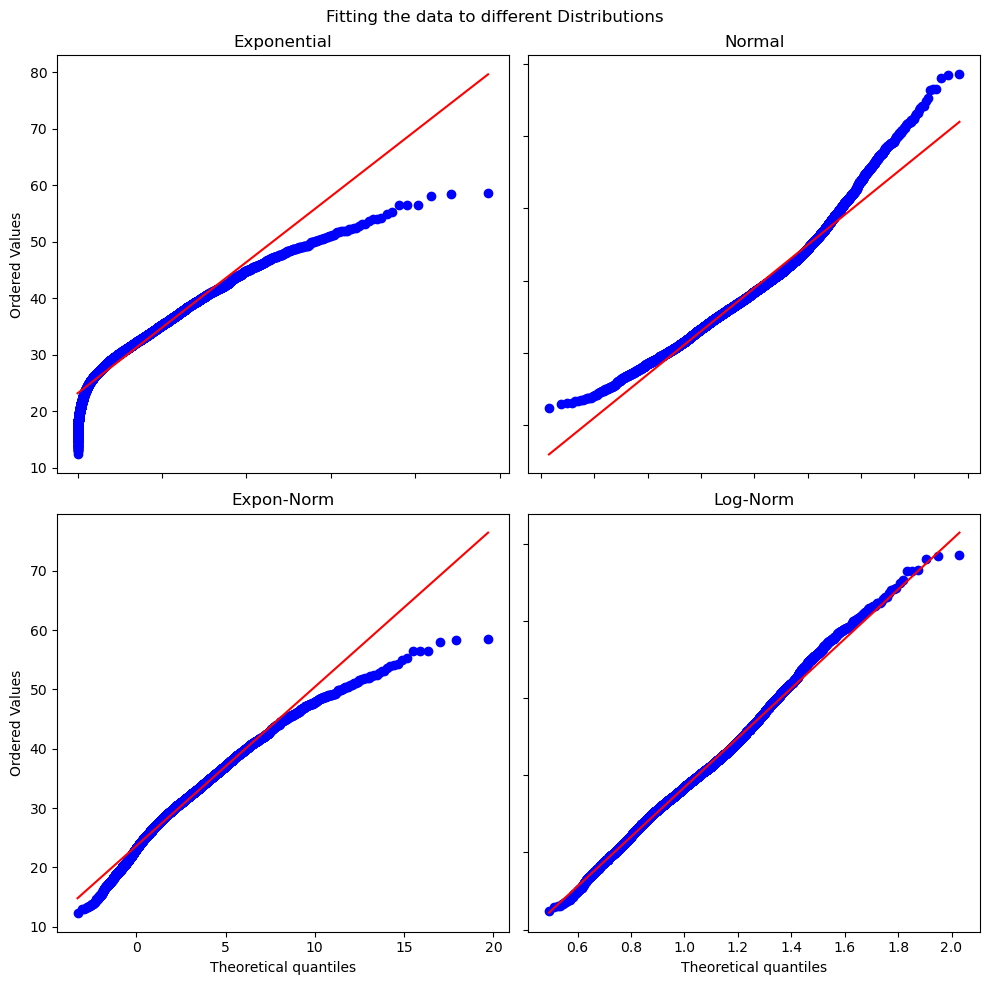

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Fitting the data to different Distributions')
stats.probplot(df['AIS length'], dist='expon', plot=axs[0,0])
axs[0,0].set_title('Exponential')
stats.probplot(df['AIS length'], dist='norm', plot=axs[0,1])
axs[0,1].set_title('Normal')
stats.probplot(df['AIS length'], dist=stats.exponnorm(K=2), plot=axs[1,0])
axs[1,0].set_title('Expon-Norm')
stats.probplot(df['AIS length'], dist=stats.lognorm(s=0.184), plot=axs[1,1])
axs[1,1].set_title('Log-Norm')
for ax in axs.flat:
        ax.set(xlabel='Theoretical quantiles', ylabel='Ordered Values')
        ax.label_outer()
plt.tight_layout()
plt.show()

### Test normal distribution of data using stats.normal test (Pearson's), Shapiro-Wilk test \& Kolmogorov-Smirnov Test (log-normal distribution)

In [7]:
print (stats.normaltest(df['AIS length'], axis=0))
print (stats.kstest(df['AIS length'], 'norm'))

NormaltestResult(statistic=1015.6755529467657, pvalue=2.810968478682094e-221)
KstestResult(statistic=1.0, pvalue=0.0, statistic_location=12.355, statistic_sign=-1)


In [8]:
print(stats.lognorm.fit(df['AIS length']))

(0.18469023863278494, -3.3353488124884727, 31.762678742224907)


In [9]:
from scipy.stats import boxcox

data = boxcox(df['AIS length'], 0) #using box-cox to transform data into log(0)
print(data)
print(stats.normaltest(data, axis=0))
df['log_normal_AIS_length'] = data

[3.03970131 3.33608981 3.23828622 ... 3.26323715 3.0419477  2.87446819]
NormaltestResult(statistic=66.65982131842188, pvalue=3.349683071032869e-15)


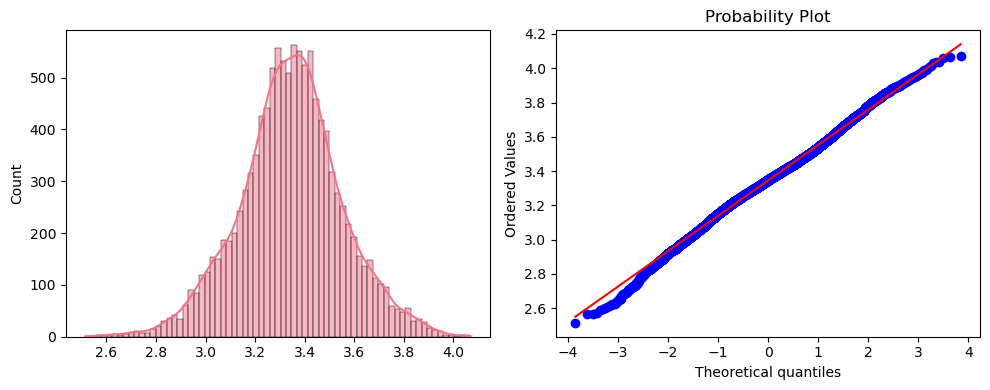

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))

sns.histplot(data=data, kde=True, ax=axs[0])
stats.probplot(data, dist='norm', plot=axs[1])


plt.tight_layout()
plt.show()

### Create a new data frame segregated by Brain region & Genotype

In [11]:
unique_values = df['Brain region'].unique()
data_dict = {}

for value in unique_values:
    subset = df.loc[(df['Brain region'] == value), 'AIS length']
    data_dict[value] = subset.tolist()

# Create a new DataFrame from the dictionary
BR_df = pd.DataFrame.from_dict(data_dict, orient='index').T #.T transforms the rows and columns

BR_df.head()

,CA1,mPFC L5,CA3,BA,S1L4,S1L5,V1L5,mPFC L23,S1L23,V1L23,LA
0,20.899,23.855,27.342,27.623,23.650,33.030,35.453,29.223,31.685,32.128,23.928
1,28.109,27.164,31.748,48.701,28.960,35.273,34.732,25.581,35.080,30.928,18.070
2,25.490,26.665,35.787,42.014,24.293,41.052,32.721,25.500,24.628,29.674,25.273
3,30.017,22.786,36.495,30.563,26.571,34.997,38.689,34.293,26.641,32.137,20.955
4,23.697,22.191,43.302,36.586,23.334,31.223,30.549,24.583,28.984,28.134,22.179


In [12]:
BR_df.isnull().sum()

CA1         110
mPFC L5      88
CA3         365
BA          519
S1L4         34
S1L5        142
V1L5         38
mPFC L23      0
S1L23        43
V1L23        38
LA          633
dtype: int64

In [13]:
genotype_WT = df.loc[(df['Genotype'] == 'WT'), ['Brain region', 'AIS length']]
genotype_KO = df.loc[(df['Genotype'] == 'KO'), ['Brain region', 'AIS length']]
print(genotype_WT.head())
print(genotype_KO.head())

  Brain region  AIS length
0          CA1      20.899
1          CA1      28.109
2          CA1      25.490
3          CA1      30.017
4          CA1      23.697
    Brain region  AIS length
307          CA1      31.374
308          CA1      22.746
309          CA1      31.564
310          CA1      25.691
311          CA1      33.093


In [14]:
unique_values_2 = genotype_WT['Brain region'].unique()
data_dict_2 = {}

for value in unique_values_2:
    subset = genotype_WT.loc[(genotype_WT['Brain region'] == value), 'AIS length']
    data_dict_2[value] = subset.tolist()

# Create a new DataFrame from the dictionary
WT_BR_df = pd.DataFrame.from_dict(data_dict_2, orient='index').T #.T transforms the rows and columns

WT_BR_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 620 entries, 0 to 619
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   CA1       620 non-null    float64
 1   mPFC L5   580 non-null    float64
 2   CA3       486 non-null    float64
 3   BA        358 non-null    float64
 4   S1L4      601 non-null    float64
 5   S1L5      601 non-null    float64
 6   V1L5      600 non-null    float64
 7   mPFC L23  618 non-null    float64
 8   S1L23     593 non-null    float64
 9   V1L23     600 non-null    float64
 10  LA        305 non-null    float64
dtypes: float64(11)
memory usage: 53.4 KB


In [15]:
unique_values_3 = genotype_KO['Brain region'].unique()
data_dict_3 = {}

for value in unique_values_3:
    subset = genotype_KO.loc[(genotype_KO['Brain region'] == value), 'AIS length']
    data_dict_3[value] = subset.tolist()

# Create a new DataFrame from the dictionary
KO_BR_df = pd.DataFrame.from_dict(data_dict_3, orient='index').T #.T transforms the rows and columns

KO_BR_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 620 entries, 0 to 619
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   CA1       508 non-null    float64
 1   mPFC L5   570 non-null    float64
 2   CA3       387 non-null    float64
 3   BA        361 non-null    float64
 4   S1L4      603 non-null    float64
 5   S1L5      495 non-null    float64
 6   V1L5      600 non-null    float64
 7   mPFC L23  620 non-null    float64
 8   S1L23     602 non-null    float64
 9   V1L23     600 non-null    float64
 10  LA        300 non-null    float64
dtypes: float64(11)
memory usage: 53.4 KB


### Check normality & QQ plot by brain region

In [16]:
#Wrote a function that would allow interative checking (by column) of data normality.

def norm_dist(df):
    for column in df:
        stat, p = stats.shapiro(df[column].dropna())
        alpha = 0.05
        if p <= alpha:
            print (f'{column} Sample is NOT Gaussian', stats.shapiro(df[column].dropna())) #Given that different columns have different values, use dropna to drop null values
        else:
            print(f'{column} Sample IS Gaussian', stats.shapiro(df[column].dropna()))

In [17]:
#Wrote a function that would allow for itnerative plotting of QQ plots for each data frame.

def qplot_2(df):
    num_cols = df.shape[1] # No. of columns in dataframe
    num_rows = int(np.ceil(num_cols / 4)) #divide this to get even dsitribution of rows
    
    fig, axs = plt.subplots(num_rows, 4, figsize=(15,15)) # Adjust figsize as needed
    fig.suptitle('QQ plots')
    axs = axs.flatten() # Flatten the axes array for easy indexing
    
    #This bit generates the actual plot 
    for i, column in enumerate(df.columns):
        column_data = df[column].values #values are now ion a numpy array
        column_data = column_data[~np.isnan(column_data)]  #drop null values
        qqplot(column_data,  line='s', ax=axs[i])
        axs[i].set_title(f'{df[column].name}')
        
    for j in range(num_cols, num_rows * 4): # Remove any extra empty subplots
        fig.delaxes(axs[j])
        
    for ax in axs.flat:
        ax.set(xlabel='Theoretical quantiles', ylabel='Ordered Values')
        ax.label_outer()   # Hide x labels and tick labels for top plots and y ticks for right plots.
        
    plt.tight_layout()
    plt.show()

In [18]:
print('Overall Brain region specific data distribution is:')
norm_dist(BR_df)

Overall Brain region specific data distribution is:
CA1 Sample is NOT Gaussian ShapiroResult(statistic=0.9912214875221252, pvalue=2.9234699923108565e-06)
mPFC L5 Sample is NOT Gaussian ShapiroResult(statistic=0.9916272163391113, pvalue=4.072220690432005e-06)
CA3 Sample IS Gaussian ShapiroResult(statistic=0.9969217777252197, pvalue=0.09188143908977509)
BA Sample is NOT Gaussian ShapiroResult(statistic=0.9948017597198486, pvalue=0.015100635588169098)
S1L4 Sample is NOT Gaussian ShapiroResult(statistic=0.9686671495437622, pvalue=1.8240471236712725e-15)
S1L5 Sample is NOT Gaussian ShapiroResult(statistic=0.9751485586166382, pvalue=9.075733328929581e-13)
V1L5 Sample is NOT Gaussian ShapiroResult(statistic=0.9969671368598938, pvalue=0.02105589583516121)
mPFC L23 Sample is NOT Gaussian ShapiroResult(statistic=0.9942180514335632, pvalue=0.00010059061605716124)
S1L23 Sample is NOT Gaussian ShapiroResult(statistic=0.9893325567245483, pvalue=1.2375932101349463e-07)
V1L23 Sample is NOT Gaussian Sh

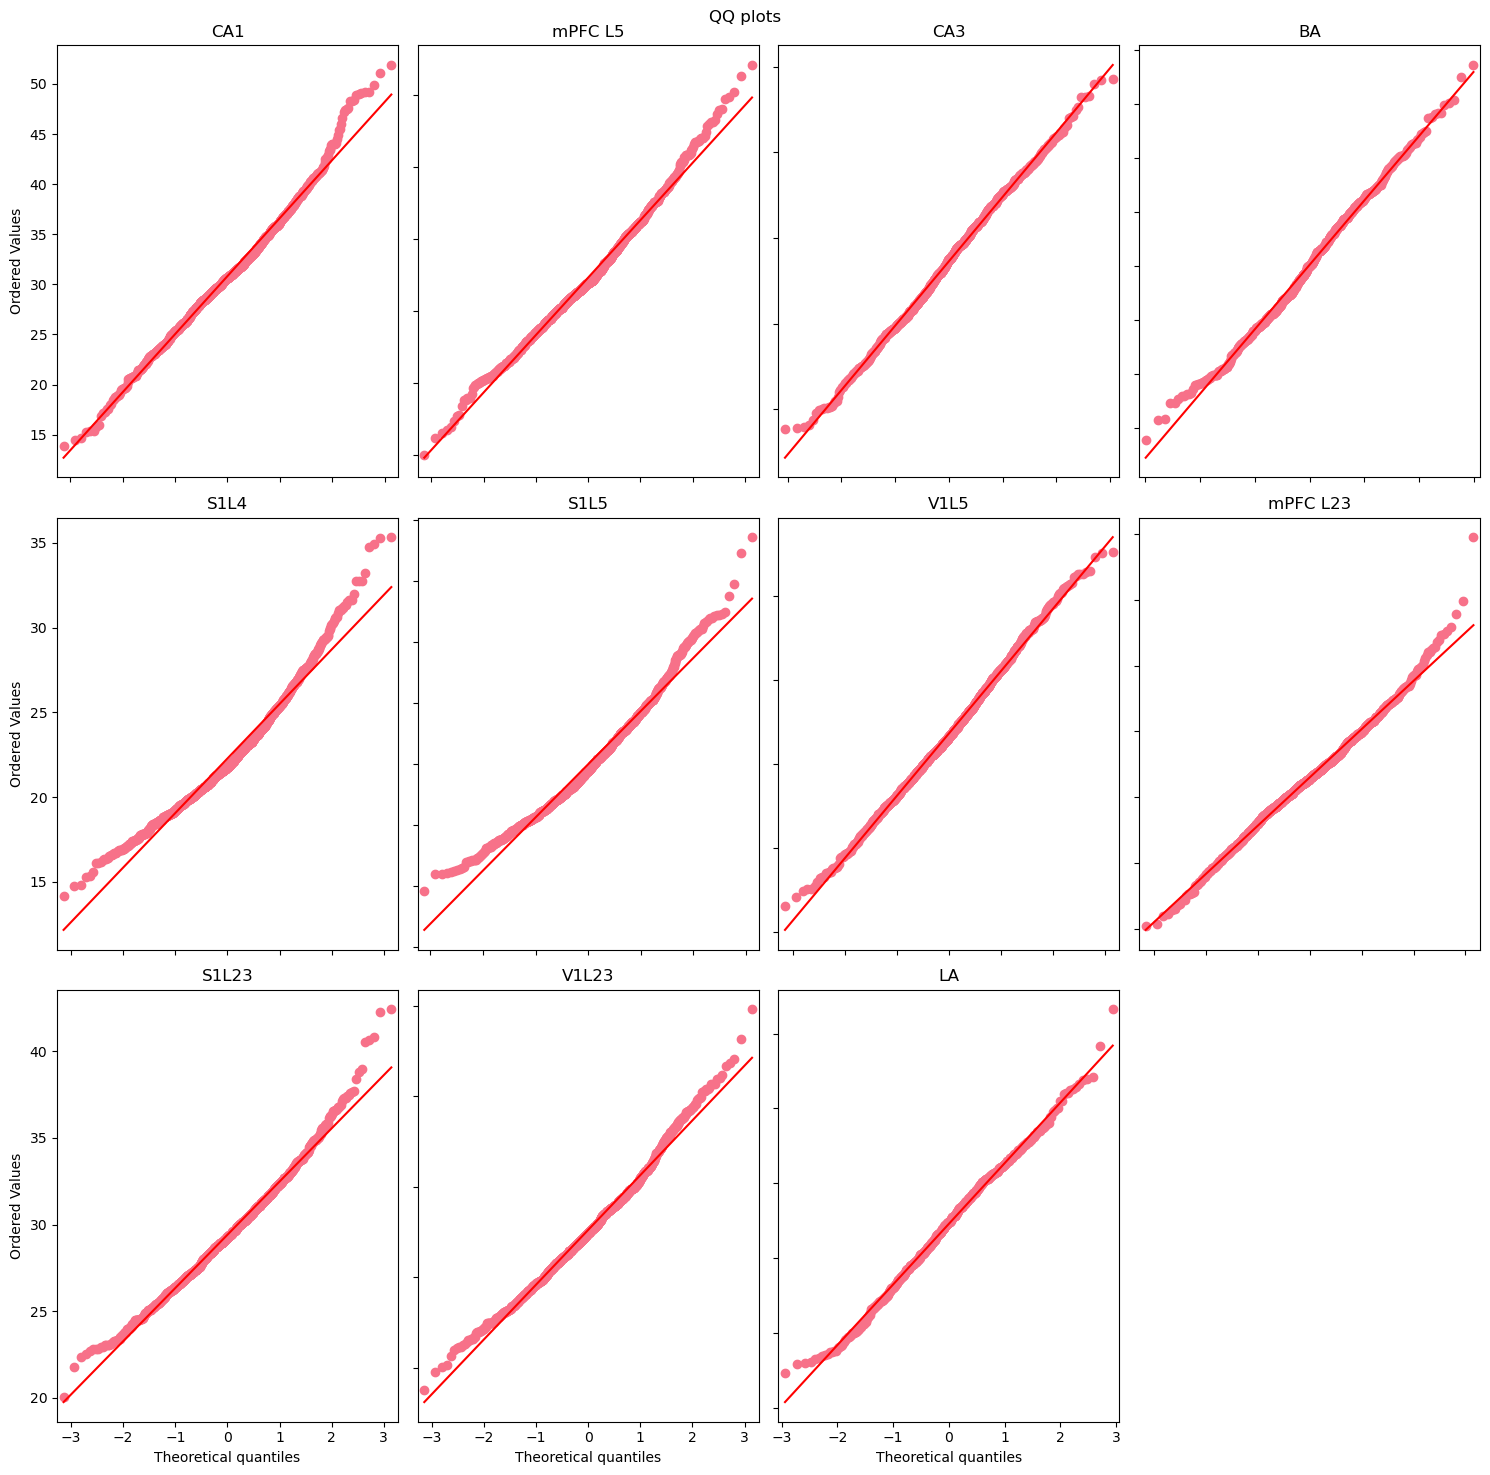

In [19]:
qplot_2(BR_df)

In [20]:
print('WT data distribution is:')
norm_dist(WT_BR_df)

WT data distribution is:
CA1 Sample IS Gaussian ShapiroResult(statistic=0.9953179359436035, pvalue=0.05775231122970581)
mPFC L5 Sample IS Gaussian ShapiroResult(statistic=0.9970847964286804, pvalue=0.3909446597099304)
CA3 Sample IS Gaussian ShapiroResult(statistic=0.9966944456100464, pvalue=0.4233284890651703)
BA Sample is NOT Gaussian ShapiroResult(statistic=0.990768551826477, pvalue=0.024237465113401413)
S1L4 Sample is NOT Gaussian ShapiroResult(statistic=0.9715446829795837, pvalue=2.087507944281697e-09)
S1L5 Sample is NOT Gaussian ShapiroResult(statistic=0.9679206013679504, pvalue=3.4657379743840977e-10)
V1L5 Sample IS Gaussian ShapiroResult(statistic=0.9977602362632751, pvalue=0.6130185723304749)
mPFC L23 Sample is NOT Gaussian ShapiroResult(statistic=0.9926878213882446, pvalue=0.00404421566054225)
S1L23 Sample is NOT Gaussian ShapiroResult(statistic=0.9901204705238342, pvalue=0.0005154398386366665)
V1L23 Sample is NOT Gaussian ShapiroResult(statistic=0.9882358312606812, pvalue=9.4

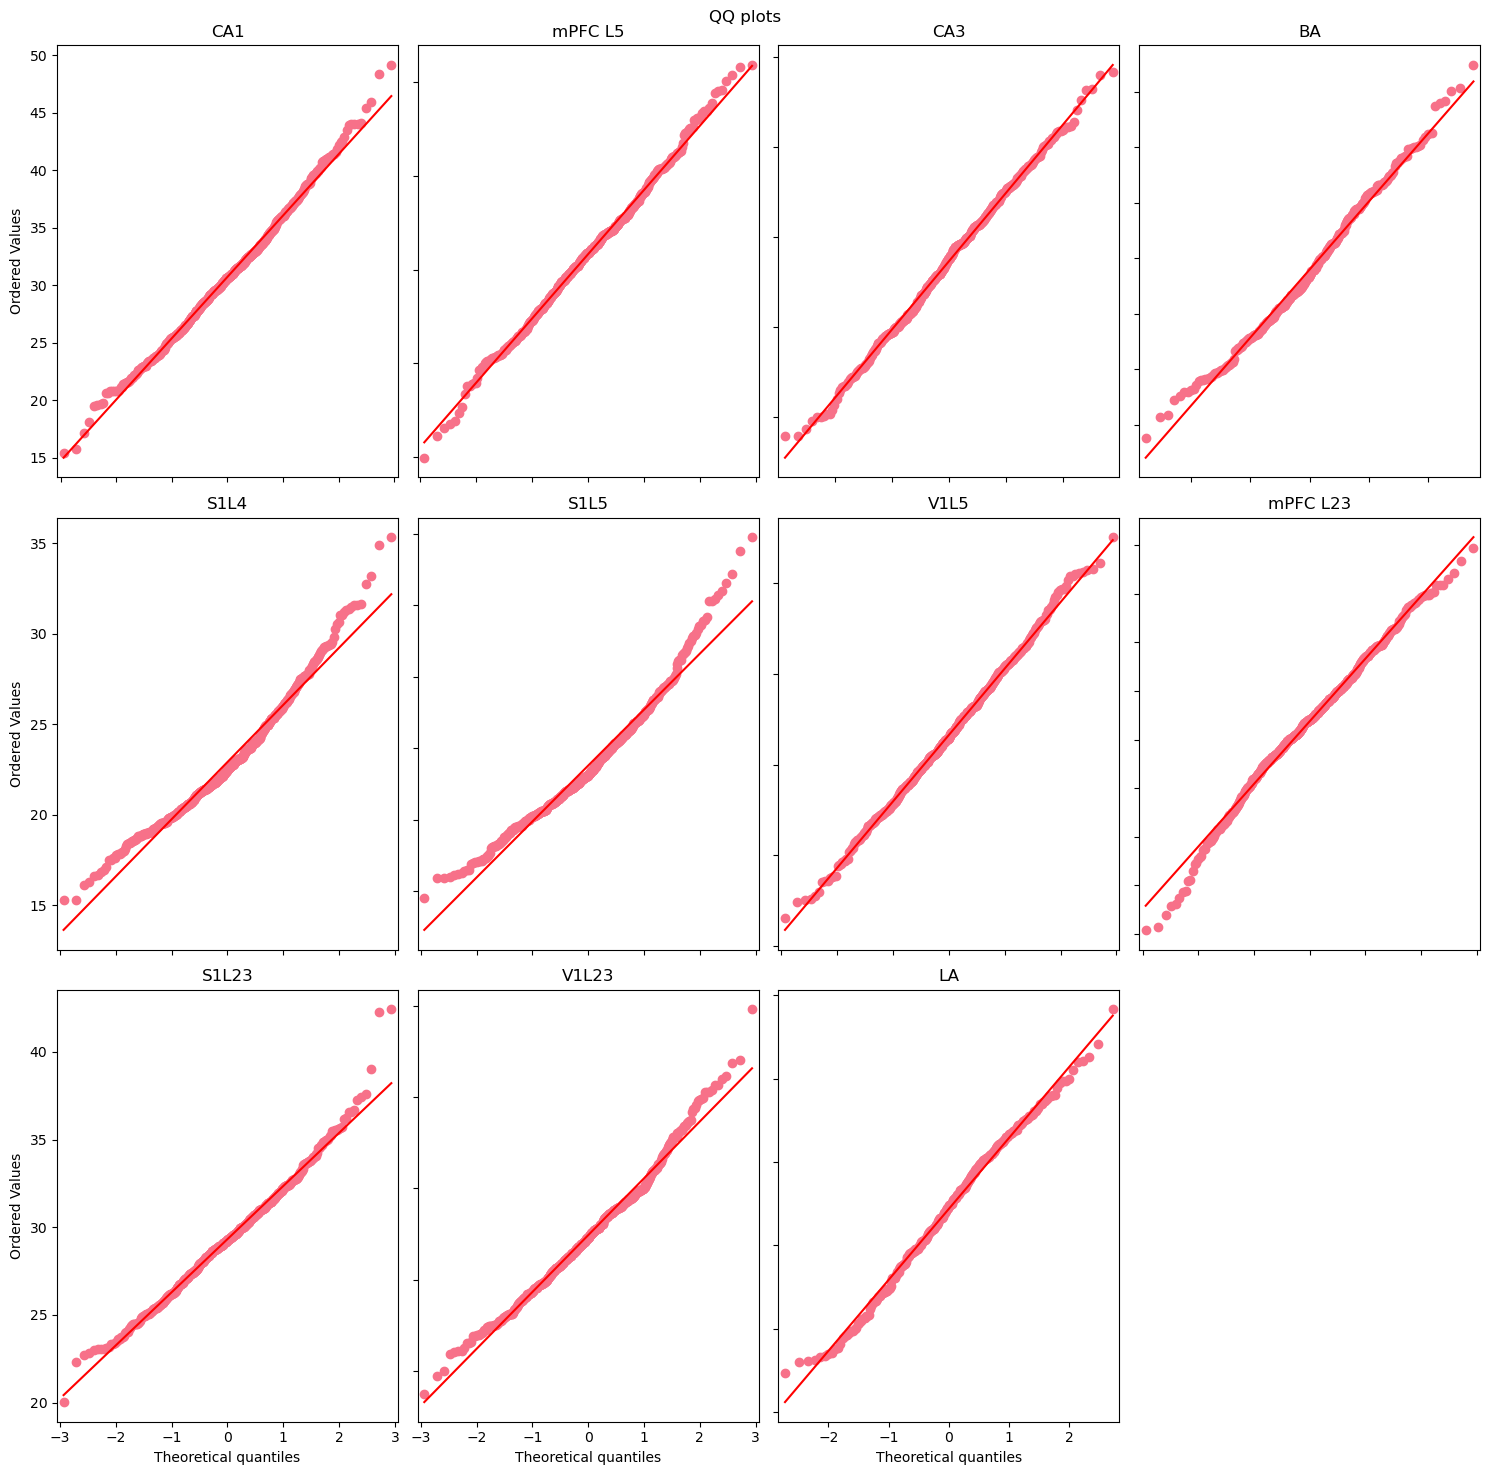

In [21]:
qplot_2(WT_BR_df)

In [22]:
print('KO data distribution is:')
norm_dist(KO_BR_df)

KO data distribution is:
CA1 Sample is NOT Gaussian ShapiroResult(statistic=0.9843248128890991, pvalue=2.743047480180394e-05)
mPFC L5 Sample is NOT Gaussian ShapiroResult(statistic=0.9883999824523926, pvalue=0.00017314446449745446)
CA3 Sample IS Gaussian ShapiroResult(statistic=0.9959622621536255, pvalue=0.42815250158309937)
BA Sample IS Gaussian ShapiroResult(statistic=0.9945473074913025, pvalue=0.22820216417312622)
S1L4 Sample is NOT Gaussian ShapiroResult(statistic=0.9575979113578796, pvalue=3.639534854049664e-12)
S1L5 Sample is NOT Gaussian ShapiroResult(statistic=0.9823286533355713, pvalue=1.017212252918398e-05)
V1L5 Sample is NOT Gaussian ShapiroResult(statistic=0.9938700199127197, pvalue=0.01566917449235916)
mPFC L23 Sample is NOT Gaussian ShapiroResult(statistic=0.9942062497138977, pvalue=0.018266411498188972)
S1L23 Sample is NOT Gaussian ShapiroResult(statistic=0.9851774573326111, pvalue=8.52306402521208e-06)
V1L23 Sample is NOT Gaussian ShapiroResult(statistic=0.9898394942283

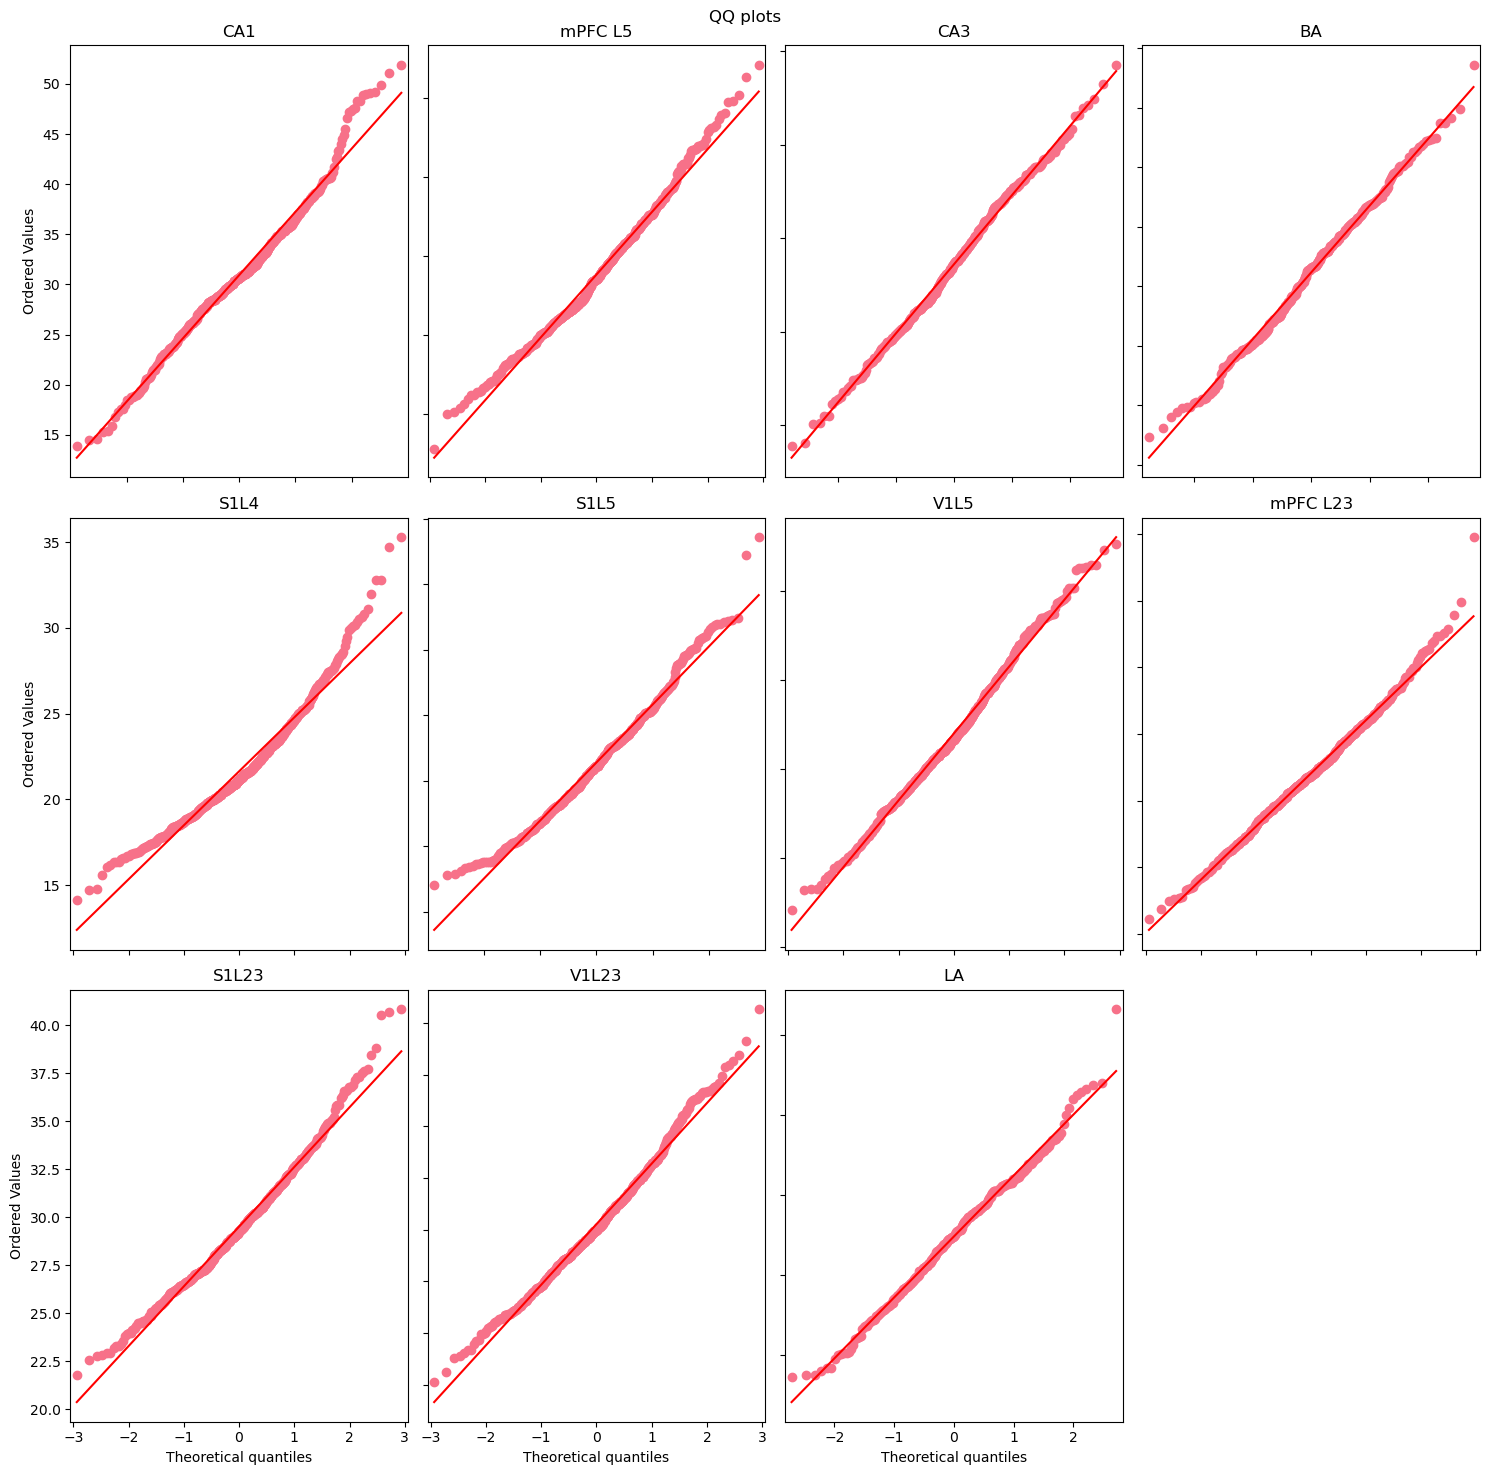

In [23]:
qplot_2(KO_BR_df)

## Running the Mixed Effects Model

In [24]:
df.rename(columns={'AIS length': 'AIS_length', 'Brain region': 'Brain_region'}, inplace=True)
df.head()

,Brain_region,Animal,Genotype,Age,Parent,AIS_length,log_normal_AIS_length
0,CA1,214,WT,P27,Fmr1/GFP19,20.899,3.039701
1,CA1,214,WT,P27,Fmr1/GFP19,28.109,3.336090
2,CA1,214,WT,P27,Fmr1/GFP19,25.490,3.238286
3,CA1,214,WT,P27,Fmr1/GFP19,30.017,3.401764
4,CA1,214,WT,P27,Fmr1/GFP19,23.697,3.165348


In [34]:
print(df['Genotype'].value_counts())
print(df['Brain_region'].value_counts())

WT    5962
KO    5646
Name: Genotype, dtype: int64
mPFC L23    1238
S1L4        1204
V1L5        1200
V1L23       1200
S1L23       1195
mPFC L5     1150
CA1         1128
S1L5        1096
CA3          873
BA           719
LA           605
Name: Brain_region, dtype: int64


In [25]:
endog = df['AIS_length']
exog = df[['Genotype', 'Brain_region']]
rndm = df[['Age', 'Parent']]

In [46]:
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM

md = smf.mixedlm("log_normal_AIS_length ~ Animal", df, groups=df["Brain_region"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_normal_AIS_length
No. Observations: 11608   Method:             REML                 
No. Groups:       11      Scale:              0.0225               
Min. group size:  605     Log-Likelihood:     5496.7915            
Max. group size:  1238    Converged:          Yes                  
Mean group size:  1055.3                                           
---------------------------------------------------------------------
                Coef.    Std.Err.      z      P>|z|   [0.025   0.975]
---------------------------------------------------------------------
Intercept        4.182      0.094    44.663   0.000    3.999    4.366
Animal          -0.004      0.000   -10.437   0.000   -0.005   -0.003
Group Var        0.026      0.078                                    



In [35]:
md = smf.mixedlm("log_normal_AIS_length ~ Genotype", df, groups=df["Brain_region"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_normal_AIS_length
No. Observations: 11608   Method:             REML                 
No. Groups:       11      Scale:              0.0226               
Min. group size:  605     Log-Likelihood:     5483.6411            
Max. group size:  1238    Converged:          Yes                  
Mean group size:  1055.3                                           
---------------------------------------------------------------------
                 Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
---------------------------------------------------------------------
Intercept         3.360      0.049   68.509   0.000    3.264    3.457
Genotype[T.WT]   -0.025      0.003   -8.850   0.000   -0.030   -0.019
Group Var         0.026      0.080                                   



In [26]:
md = smf.mixedlm("log_normal_AIS_length ~ Genotype", df, groups=df["Animal"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_normal_AIS_length
No. Observations: 11608   Method:             REML                 
No. Groups:       12      Scale:              0.0420               
Min. group size:  684     Log-Likelihood:     1898.2501            
Max. group size:  1067    Converged:          Yes                  
Mean group size:  967.3                                            
--------------------------------------------------------------------
                    Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept            3.351     0.013  266.087  0.000   3.327   3.376
Genotype[T.WT]      -0.015     0.018   -0.860  0.390  -0.050   0.020
Group Var            0.001     0.002                                



C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [53]:
md = smf.mixedlm("log_normal_AIS_length ~ Brain_region", df, groups='Parent')
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: log_normal_AIS_length
No. Observations:  11608   Method:             REML                 
No. Groups:        2       Scale:              0.0226               
Min. group size:   5687    Log-Likelihood:     inf                  
Max. group size:   5921    Converged:          Yes                  
Mean group size:   5804.0                                           
--------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                 0.289                                     
Brain_region[T.CA1]      -0.132    0.007 -18.447 0.000 -0.147 -0.118
Brain_region[T.CA3]       0.054    0.008   7.149 0.000  0.039  0.069
Brain_region[T.LA]       -0.456    0.008 -54.936 0.000 -0.472 -0.440
Brain_region[T.S1L23]    -0.167    0.007 -23.564 0

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\ProgramDa

In [28]:
md = smf.mixedlm("AIS_length ~ Genotype * Brain_region", df, groups=df["Genotype"], re_formula="~Parent + Age")
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

                              Mixed Linear Model Regression Results
Model:                           MixedLM              Dependent Variable:              AIS_length 
No. Observations:                11608                Method:                          REML       
No. Groups:                      2                    Scale:                           19.1987    
Min. group size:                 5646                 Log-Likelihood:                  -33629.3781
Max. group size:                 5962                 Converged:                       Yes        
Mean group size:                 5804.0                                                           
--------------------------------------------------------------------------------------------------
                                         Coef.    Std.Err.     z    P>|z|    [0.025       0.975]  
--------------------------------------------------------------------------------------------------
Intercept                                

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [54]:
md = smf.mixedlm("log_normal_AIS_length ~ Genotype", df, groups=df["Brain_region"], re_formula="~Parent + Age")
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

                      Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     log_normal_AIS_length
No. Observations:       11608       Method:                 REML                 
No. Groups:             11          Scale:                  0.0224               
Min. group size:        605         Log-Likelihood:         5529.8994            
Max. group size:        1238        Converged:              Yes                  
Mean group size:        1055.3                                                   
---------------------------------------------------------------------------------
                                      Coef.   Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                              3.371     0.066 50.792 0.000  3.241  3.501
Genotype[T.WT]                        -0.026     0.003 -9.167 0.000 -0.031 -0.020
Group Var                             

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [58]:
#Trying different optimizers & methods:

md = smf.mixedlm("log_normal_AIS_length ~ Genotype*Brain_region", df, groups=df["Brain_region"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

                      Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      log_normal_AIS_length
No. Observations:      11608        Method:                  REML                 
No. Groups:            11           Scale:                   0.0221               
Min. group size:       605          Log-Likelihood:          5580.0631            
Max. group size:       1238         Converged:               Yes                  
Mean group size:       1055.3                                                     
----------------------------------------------------------------------------------
                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------
Intercept                                3.576    0.149 24.029 0.000  3.284  3.867
Genotype[T.WT]                          -0.066    0.011 -5.957 0.000 -0.088 -0.044
Brain_region[T.CA1]        

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
